# Clonal clustering and the embedding to the combined data

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import sclitr as sl
import seaborn as sns
import sys
import scanpy.external as sce
import anndata as ad
import symphonypy as sp
import numpy as np

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: 

In [ ]:
# Created using assistence from AI.
# From Claude, code was tested in person to make sure it does what it intends.
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

def optimize_n_neighbors(adata, n_neighbors_range=range(3, 200, 1)):
    """
    Find optimal number of nearest neighbors using multiple metrics:
    1. Silhouette score on leiden clusters
    2. Elbow method on k-distance graph
    3. Local connectivity preservation
    
    Parameters
    ----------
    adata : AnnData object
        Annotated data matrix with normalized and scaled counts
    n_neighbors_range : range or list
        Range of n_neighbors values to test
        
    Returns
    -------
    dict
        Dictionary containing optimal n_neighbors values for different metrics
        and evaluation results
    """
    results = {
        'silhouette_scores': [],
        'kdist_scores': [],
        'connectivity_scores': [],
        'n_neighbors_tested': list(n_neighbors_range)
    }
    
    # Store original n_neighbors if exists
    original_n_neighbors = adata.uns['neighbors']['params']['n_neighbors'] if 'neighbors' in adata.uns else None
    
    for n in n_neighbors_range:
        print(f"Testing n_neighbors = {n}")
        
        # 1. Compute neighbor graph and run clustering
        sc.pp.neighbors(adata, n_neighbors=n, use_rep='X_pca')
        sc.tl.leiden(adata, resolution=2.5)
        
        # Calculate silhouette score
        sil_score = silhouette_score(adata.X, adata.obs['leiden'])
        results['silhouette_scores'].append(sil_score)
        
        # 2. K-distance graph
        nbrs = NearestNeighbors(n_neighbors=n).fit(adata.X)
        distances, _ = nbrs.kneighbors(adata.X)
        kdist = np.mean(distances[:, -1])
        results['kdist_scores'].append(kdist)
        
        # 3. Local connectivity preservation
        # Calculate the ratio of points that maintain mutual nearest neighbor relationships
        connectivity_matrix = adata.obsp['connectivities']
        mutual_connections = (connectivity_matrix.multiply(connectivity_matrix.T) != 0).sum() / 2
        total_possible = n * adata.n_obs
        connectivity_score = mutual_connections / total_possible
        results['connectivity_scores'].append(connectivity_score)
    
    # Find optimal values
    # For silhouette score - higher is better
    optimal_silhouette = n_neighbors_range[np.argmax(results['silhouette_scores'])]
    
    # For k-distance - use elbow method
    kl = KneeLocator(list(n_neighbors_range), results['kdist_scores'], 
                     curve='convex', direction='increasing')
    optimal_kdist = kl.elbow if kl.elbow else n_neighbors_range[0]
    
    # For connectivity - higher is better but with diminishing returns
    kl_connectivity = KneeLocator(list(n_neighbors_range), results['connectivity_scores'],
                                 curve='convex', direction='increasing')
    optimal_connectivity = kl_connectivity.elbow if kl_connectivity.elbow else n_neighbors_range[0]
    
    # Plotting results
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    
    axs[0].plot(n_neighbors_range, results['silhouette_scores'])
    axs[0].set_title('Silhouette Score vs n_neighbors')
    axs[0].axvline(x=optimal_silhouette, color='r', linestyle='--')
    
    axs[1].plot(n_neighbors_range, results['kdist_scores'])
    axs[1].set_title('Average k-distance vs n_neighbors')
    axs[1].axvline(x=optimal_kdist, color='r', linestyle='--')
    
    axs[2].plot(n_neighbors_range, results['connectivity_scores'])
    axs[2].set_title('Connectivity Preservation vs n_neighbors')
    axs[2].axvline(x=optimal_connectivity, color='r', linestyle='--')
    
    plt.tight_layout()
    
    # Restore original n_neighbors if it existed
    if original_n_neighbors is not None:
        sc.pp.neighbors(adata, n_neighbors=original_n_neighbors, use_rep='X_pca')
    
    return {
        'optimal_silhouette': optimal_silhouette,
        'optimal_kdist': optimal_kdist,
        'optimal_connectivity': optimal_connectivity,
        'results': results,
        'figure': fig
    }

In [ ]:
DATA_PATH = "/placodes/data"

In [4]:
adata_conc = sc.read_h5ad(f"{DATA_PATH}/anndatas/cranial_placodal_integrated.h5ad")

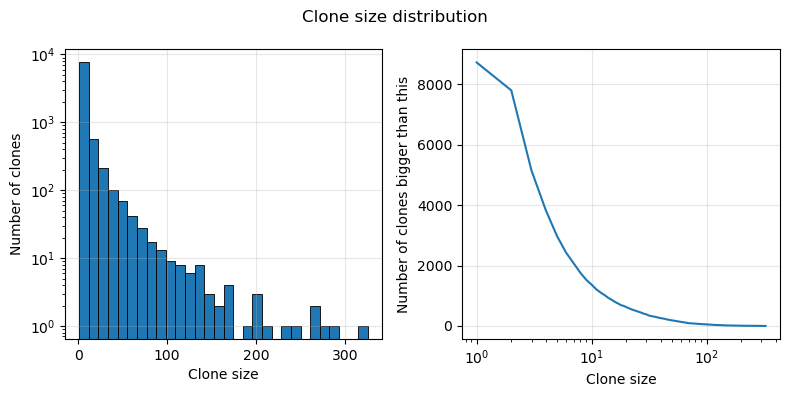

In [5]:
# Testing to view distribution of clone sizes
sl.pl.basic_stats(adata_conc, obs_name="clone_id", title="Clone size distribution")

In [7]:
# Run nearest neighbor
sl.tl.clonal_nn(
    adata_conc,
    obs_name="clone_id",
    use_rep="X_pca_harmony",
    min_size=5, # Select k
    tqdm_bar=True,
)

100%|██████████| 171093/171093 [02:43<00:00, 1044.44it/s]


In [8]:
# Run clone2vec
clones = sl.tl.clone2vec(
        adata_conc,
        obs_name="clone_id",
        fill_ct="leiden_2",
        device="cpu",
        n_epochs=50,
    )

100%|██████████| 50/50 [14:30<00:00, 17.42s/it]
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/sclitr/tl.py:223: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = adata_only_clones.obs.groupby(


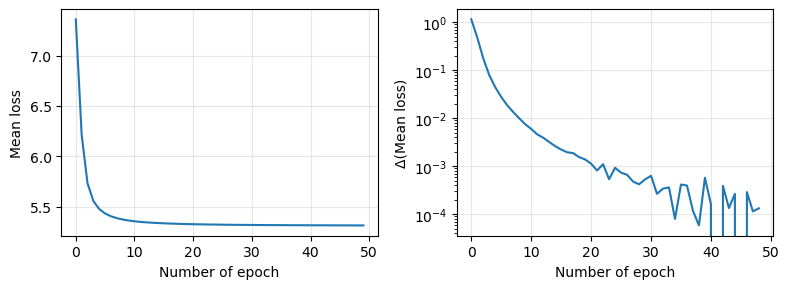

In [9]:
sl.pl.epochs_loss(clones)

Testing n_neighbors = 3


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_25744/893700938.py:43: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=2.5) #<========== Leiden can also be different


Testing n_neighbors = 4


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 5


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 6


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 7


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 8


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 9


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 10


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 11


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 12


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Testing n_neighbors = 13
Testing n_neighbors = 14
Testing n_neighbors = 15
Testing n_neighbors = 16
Testing n_neighbors = 17
Testing n_neighbors = 18
Testing n_neighbors = 19
Testing n_neighbors = 20
Testing n_neighbors = 21
Testing n_neighbors = 22
Testing n_neighbors = 23
Testing n_neighbors = 24
Testing n_neighbors = 25
Testing n_neighbors = 26
Testing n_neighbors = 27
Testing n_neighbors = 28
Testing n_neighbors = 29
Testing n_neighbors = 30
Testing n_neighbors = 31
Testing n_neighbors = 32
Testing n_neighbors = 33
Testing n_neighbors = 34
Testing n_neighbors = 35
Testing n_neighbors = 36
Testing n_neighbors = 37
Testing n_neighbors = 38
Testing n_neighbors = 39
Testing n_neighbors = 40
Testing n_neighbors = 41
Testing n_neighbors = 42
Testing n_neighbors = 43
Testing n_neighbors = 44
Testing n_neighbors = 45
Testing n_neighbors = 46
Testing n_neighbors = 47
Testing n_neighbors = 48
Testing n_neighbors = 49
Testing n_neighbors = 50
Testing n_neighbors = 51
Testing n_neighbors = 52


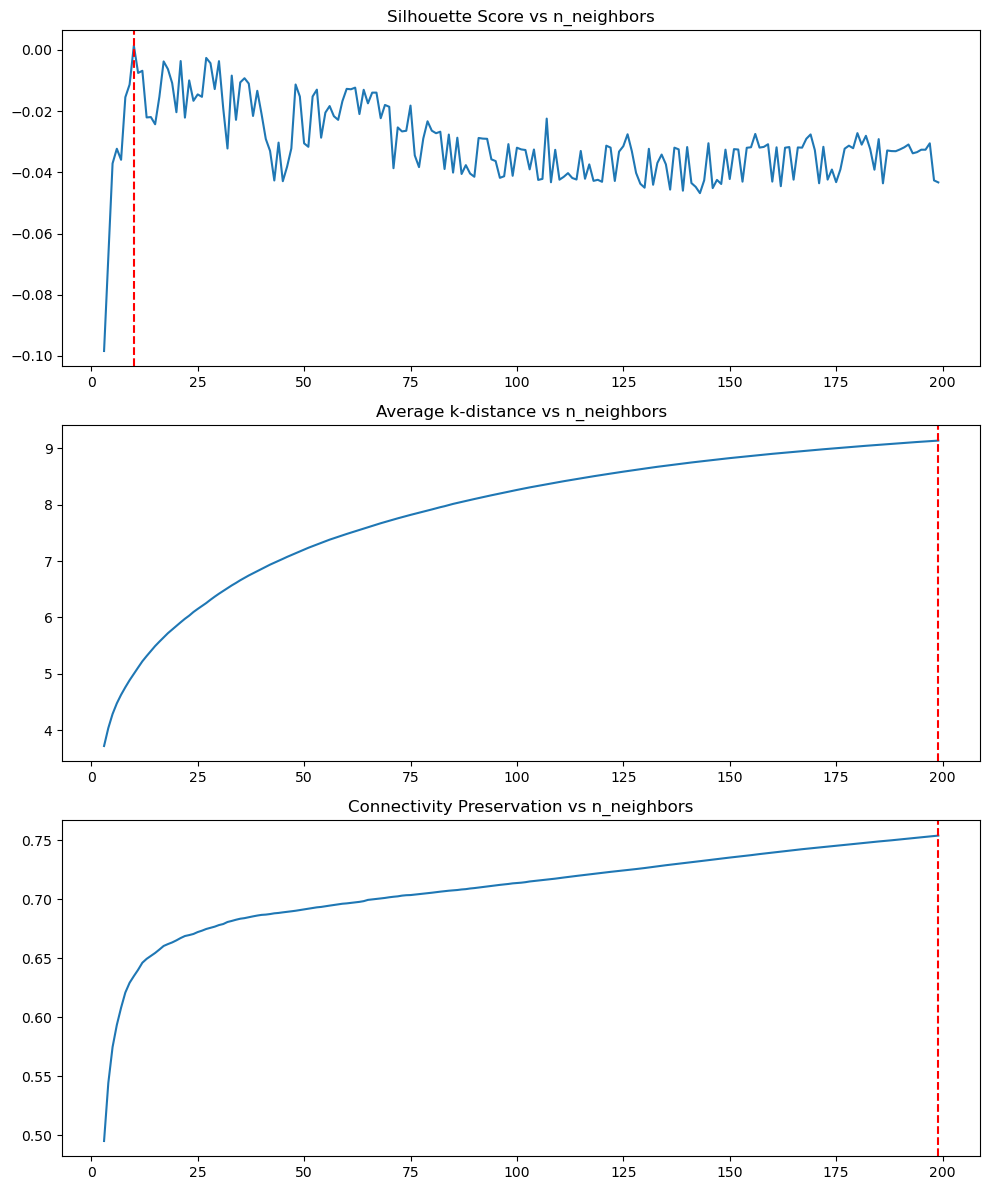

In [ ]:
sc.pp.pca(clones, n_comps=20)
results = optimize_n_neighbors(clones)

# Access the optimal values
print(f"Optimal n_neighbors based on silhouette score: {results['optimal_silhouette']}")
print(f"Optimal n_neighbors based on k-distance: {results['optimal_kdist']}")
print(f"Optimal n_neighbors based on connectivity: {results['optimal_connectivity']}")

# The function also returns a figure showing all three metrics
plt.show()

In [ ]:
# Construct kNN-graph and UMAP based on latent representation of the clones.
sc.pp.neighbors(clones, use_rep="word2vec", n_neighbors=10) # Used Silhoutte score to decide this. 
sc.tl.umap(clones, min_dist=0.25)
clones.obs["n_cells"] = clones.X.sum(axis=1)
clones.obs["lg_n_cells"] = np.log10(clones.X.sum(axis=1))

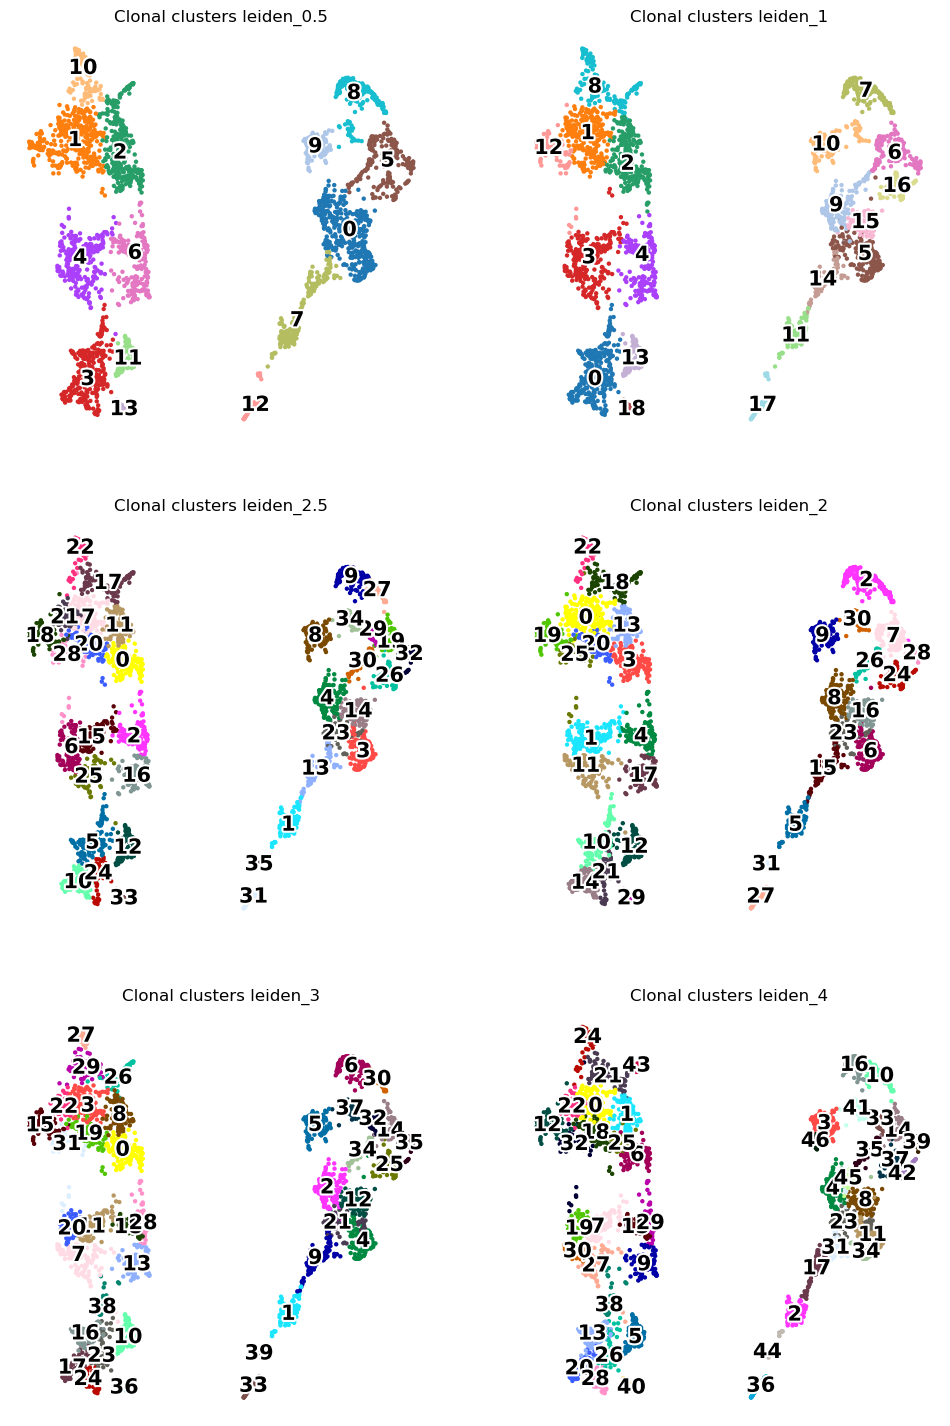

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=3 , figsize=(12,18))

# Transfer the embeddings
col=0
row=0
for resolution in [0.5, 1, 2.5, 2, 3, 4]:
    sc.tl.leiden(clones, key_added=f"leiden_{resolution}", resolution=resolution)
    leiden_mapping = dict(clones.obs[f"leiden_{resolution}"])
    adata_conc.obs[f"clones_clusters_{resolution}"] = [
        leiden_mapping[clone] if clone in leiden_mapping else "NA"
        for clone in adata_conc.obs["clone_id"]
    ]
    sc.pl.umap(
        clones,
        color=f"leiden_{str(resolution)}",
        frameon=False,
        title=f"Clonal clusters leiden_{str(resolution)}",
        legend_loc="on data",
        legend_fontsize=15,
        legend_fontoutline=3,
        show=False,
        ax=axes[col][row]
    )
    if row == 0:
        row += 1
    else:
        row -= 1
        col += 1

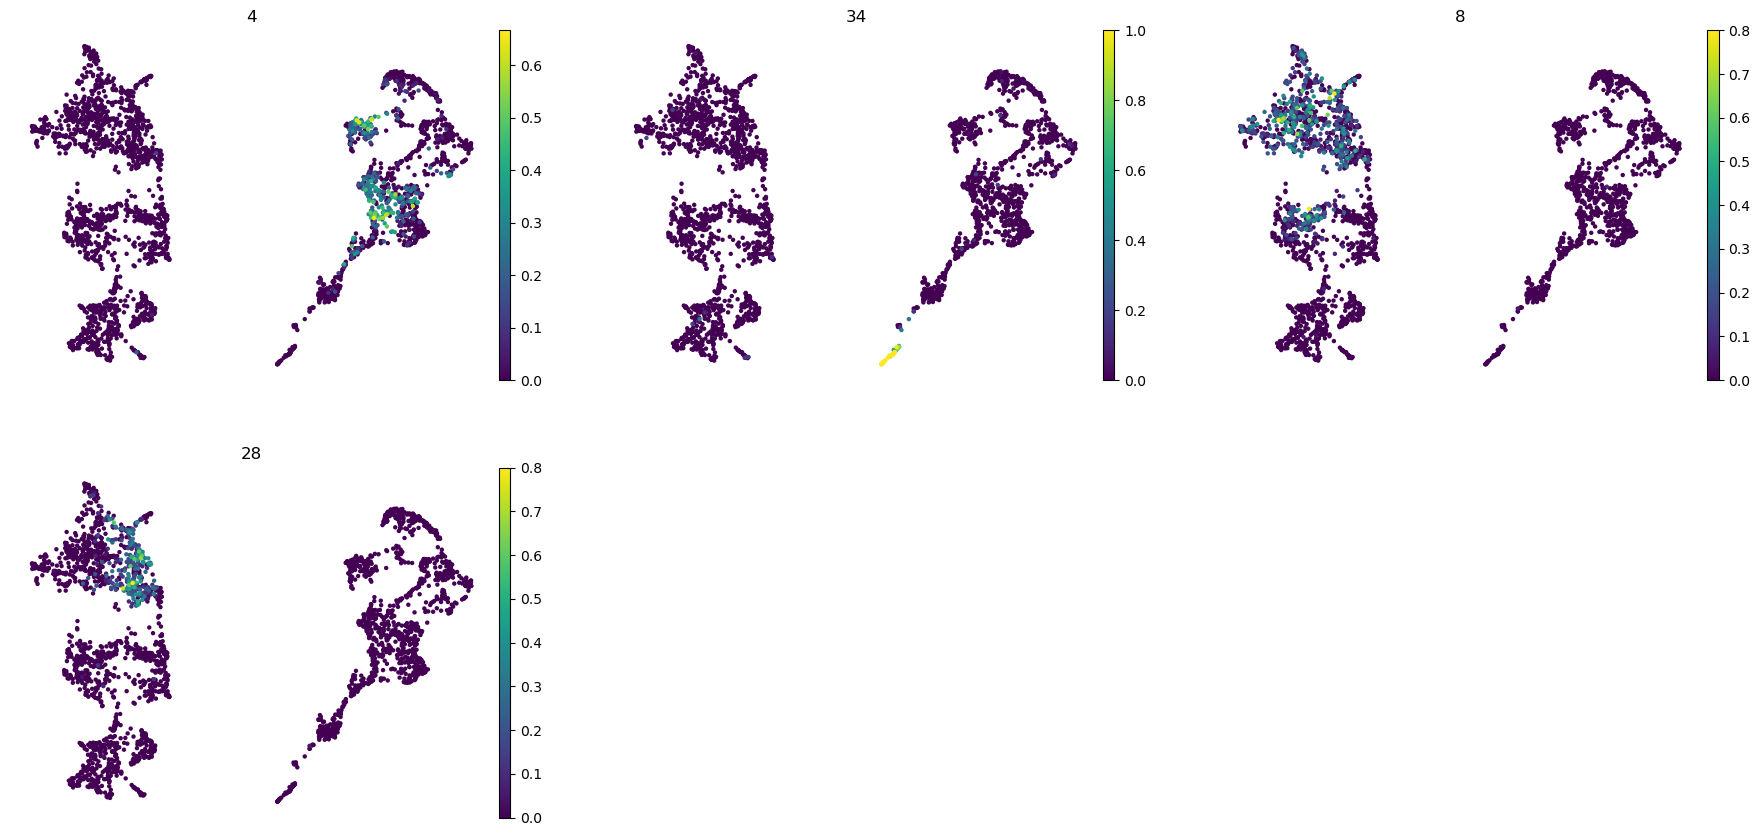

In [ ]:
# Placement of clones in the clonal UMAP embedding, clusters by NN. 
sc.pl.umap(
    clones,
    color=["4", "34", "8", "28"],
    layer="frequencies",
    frameon=False,
    cmap="viridis",
    ncols=3,
)

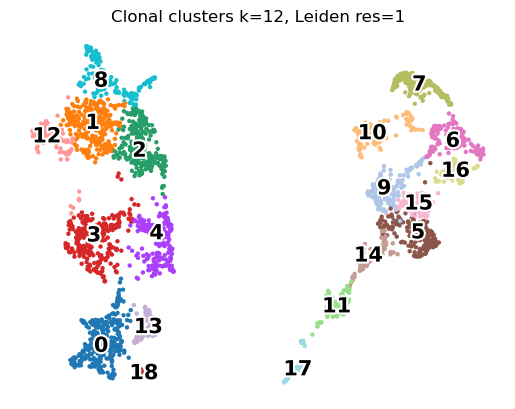

In [ ]:
# Placement of clones in the clonal UMAP embedding, clusters by leiden(res=1)
sc.pl.umap(
    clones,
    color="leiden_1",
    frameon=False,
    title="Clonal clusters k=12, Leiden res=1",
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=3
)

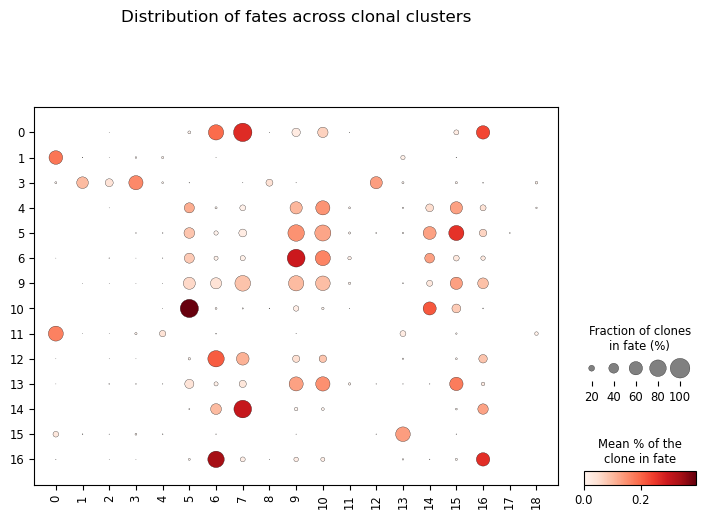

In [15]:
sc.pl.dotplot(
    clones,
    var_names=["0", "1", "3", "4", "5", "6", "9", "10", "11", "12", "13", "14", "15", "16"],
    groupby="leiden_1",
    layer="frequencies",
    colorbar_title="Mean % of the\nclone in fate",
    cmap="Reds",
    swap_axes=True,
    size_title="Fraction of clones\nin fate (%)",
    title="Distribution of fates across clonal clusters",
    dot_max=1,
)

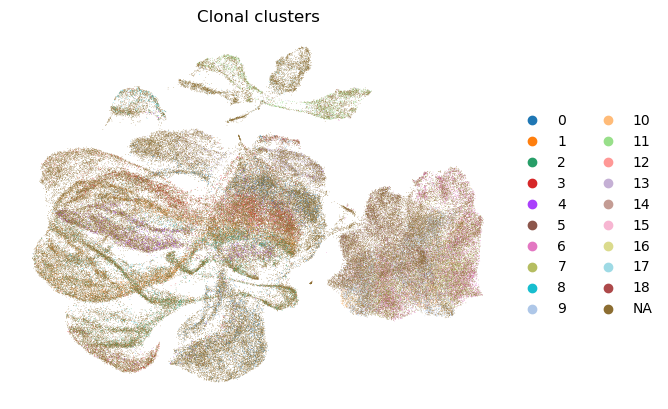

In [ ]:
# Placement of clones in the clonal UMAP embedding, clusters by leiden(res=1)
sc.pl.umap(
    adata_conc,
    color="clones_clusters_1",
    frameon=False,
    title="Clonal clusters",
)

In [17]:
# Saving data
adata_conc.write_h5ad("/home/felix/data/placodal/anndatas/cranial_placodal_integrated_clonal_clusters.h5ad")


In [18]:
# Saving data
clones.write_h5ad("/home/felix/data/placodal/anndatas/cranial_placodal_integrated_clonal_embedding.h5ad")